### Fine-Tuning the VGG16 Model

#### 1 Import the libraries:

In [3]:
import numpy as np
from keras.layers import Dense
from tensorflow import random
import keras
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

#### 2 Initiate the model:

In [4]:
vgg_model =  VGG16()
print(vgg_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### 3 Remove the last layer
Remove the last layer predictions in above, from the model summary. Create a new Keras model of the sequential class and iterate through all the layers of the VGG model. Add all of them to the new model, except for the last layer:


In [5]:
last_layer = str(vgg_model.layers[-1])
np.random.seed(42)
random.set_seed(42)
classifier= keras.Sequential()

for layer in vgg_model.layers:
    if str(layer) != last_layer:
        classifier.add(layer)

#### 4 Print the summary of the newly created model
The last layer of prediction (`Dense`) has been deleted.

In [6]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

#### 5 Freeze the layers

Freeze the layers by iterating through the layers and setting the `trainable` parameter to `False`

In [7]:
for layer in classifier.layers:

    layer.trainable=False

#### 6 Add a new layer
Add a new output layer of size `1` with a `sigmoid` activation function and print the model summary

In [8]:
classifier.add(Dense(1, activation='sigmoid'))

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

#### 7 Compile the model:
Compile the network with an `adam` optimizer and binary cross-entropy loss and compute the `accuracy` during training

In [9]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### 8 Create the data generators. 
Create some training and test data generators. Rescale the training and test images by 1/255 so that all the values are between 0 and 1. Set the following parameters for the training data generators only: `shear_range=0.2`, `zoom_range=0.2`, and `horizontal_flip=True`.

Next, create a training set from the training set folder. Our CNN model has an image size of 224x224, so the same size should be passed here too. `batch_size` is the number of images in a single batch, which is `32`. `class_mode` is binary since we are creating a binary classifier

In [10]:
import os
src = 'training_set/car/'
c=0
for image_file_name in os.listdir(src):
    c=c+1
    if c>100:
        os.remove(src + image_file_name)
        
src = 'training_set/flower/'
c=0
for image_file_name in os.listdir(src):
    c=c+1
    if c>100:
        os.remove(src + image_file_name)
        
src = 'test_set/car/'
c=0
for image_file_name in os.listdir(src):
    c=c+1
    if c>30:
        os.remove(src + image_file_name)
        
src = 'test_set/flower/'
c=0
for image_file_name in os.listdir(src):
    c=c+1
    if c>30:
        os.remove(src + image_file_name)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'training_set/car/'

In [9]:
from keras.preprocessing.image import ImageDataGenerator

generate_train_data = ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

generate_test_data = ImageDataGenerator(rescale =1./255)

training_dataset = generate_train_data.flow_from_directory('training_set',
                                             target_size = (224, 224),
                                             batch_size = 32,
                                             class_mode = 'binary')

test_dataset = generate_test_data.flow_from_directory('test_set',
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        class_mode = 'binary')


Found 200 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


#### 9 Fit the classifier


In [12]:
STEP_SIZE_TRAIN=training_dataset.n//training_dataset.batch_size
STEP_SIZE_TEST=test_dataset.n//test_dataset.batch_size

#STEP_SIZE_TRAIN=100
#STEP_SIZE_TEST=30
classifier.fit_generator(training_dataset,
                         steps_per_epoch = STEP_SIZE_TRAIN,
                         epochs = 10,
                         validation_data = test_dataset,
                         validation_steps = STEP_SIZE_TEST,
                         shuffle=False)

Epoch 1/10
6/6 [==============================] - 148s 25s/step - loss: 0.6167 - accuracy: 0.5990 - val_loss: 0.5219 - val_accuracy: 0.7500
Epoch 2/10
6/6 [==============================] - 107s 18s/step - loss: 0.5073 - accuracy: 0.7857 - val_loss: 0.4325 - val_accuracy: 0.8571
Epoch 3/10
6/6 [==============================] - 110s 18s/step - loss: 0.4500 - accuracy: 0.7798 - val_loss: 0.3788 - val_accuracy: 0.9062
Epoch 4/10
6/6 [==============================] - 101s 17s/step - loss: 0.4528 - accuracy: 0.8155 - val_loss: 0.3908 - val_accuracy: 0.8214
Epoch 5/10
6/6 [==============================] - 103s 17s/step - loss: 0.3530 - accuracy: 0.8929 - val_loss: 0.2660 - val_accuracy: 0.9688
Epoch 6/10
6/6 [==============================] - 97s 16s/step - loss: 0.3943 - accuracy: 0.8631 - val_loss: 0.4417 - val_accuracy: 0.7857
Epoch 7/10
6/6 [==============================] - 106s 18s/step - loss: 0.3431 - accuracy: 0.8929 - val_loss: 0.3001 - val_accuracy: 0.8750
Epoch 8/10
6/6 [=====

#### 10 Make the predictions. 


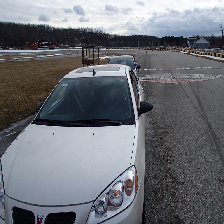

In [16]:
from keras.preprocessing import image

new_image = image.load_img('Prediction/test_image_2.jpg', target_size = (224, 224))

new_image

In [17]:
new_image = image.img_to_array(new_image)

new_image = np.expand_dims(new_image, axis = 0)
# reshape data for the model
#transformed_image = transformed_image.reshape((1, transformed_image.shape[0], transformed_image.shape[1], transformed_image.shape[2]))

result = classifier.predict(new_image)



if result[0][0] == 1:

    prediction = 'It is a flower'

else:

    prediction = 'It is a car'

print(prediction)

It is a car
